In [24]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, make_union, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn_pandas import DataFrameMapper, cross_val_score, gen_features
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
current_palette = sns.color_palette('colorblind')

In [2]:
df = pd.read_csv('default-payment.csv', index_col = 'ID')

In [3]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

Creating dictionaries for categorical variables based on PDF Problem Statement

In [4]:
sex = {0 : 'Male', 1 : 'Female'}
marriage = {1: 'married', 2: 'single', 3: 'others'}
education = {1: 'grad school', 2: 'university', 3: 'high school', 4: 'others'}
repayment = {-1: 'pay duly', 1: '1mth delay', 2: '2mth delay', 3: '3mth delay', 4: '4mth delay',
             5: '5mth delay', 6: '6mth delay', 7: '7mth delay', 8: '8mth delay', 9: '9mth or more delay'}
default = {0 : 'N', 1 : 'Y'}

Pre-Processing of categorical variables X2 to X11

In [5]:
#Coding Sex binary with 0 and 1 instead of 1 and 2
df.SEX.unique()
df.loc[(df.SEX == 1), 'SEX'] = 0
df.loc[(df.SEX == 2), 'SEX'] = 1

In [6]:
#Grouping unknown Education status together with 'Others'
df.EDUCATION.unique()
df.loc[(df.EDUCATION == 5), 'EDUCATION'] = 4
df.loc[(df.EDUCATION == 6), 'EDUCATION'] = 4
df.loc[(df.EDUCATION == 0), 'EDUCATION'] = 4

In [7]:
#Grouping unknown Marriage status together with 'Others'
df.MARRIAGE.unique()
df.loc[(df.MARRIAGE == 0), 'MARRIAGE'] = 3

In [8]:
#Grouping negative and 0 repayment timings to paying on time
df.PAY_0.unique()
pays = ['PAY_0', 'PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for p in pays:
    df.loc[(df[p] == 0), p] = -1
    df.loc[(df[p] == -2), p] = -1

In [9]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,0.603733,1.842267,1.557267,35.485500,-0.415967,-0.532033,-0.555500,-0.624233,-0.679567,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.744494,0.521405,9.217904,1.142591,1.146393,1.126275,1.067522,1.001726,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,0.000000,1.000000,1.000000,21.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,0.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,1.000000,2.000000,2.000000,34.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,1.000000,2.000000,2.000000,41.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,1.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


30,000 Credit Card clients \
Large standard deviation of limit balance \
22.1% of clients are defaulting on their payments next month

In [10]:
df.isna().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

Checking distribution of categorical variables

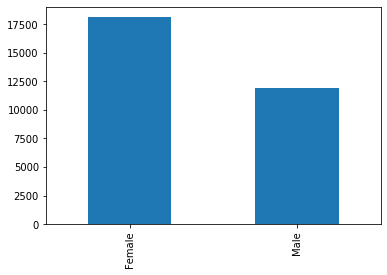

In [11]:
df.columns = df.columns.map(str.lower)
import matplotlib
%matplotlib inline
df['sex'].map(sex).value_counts().plot(kind='bar')

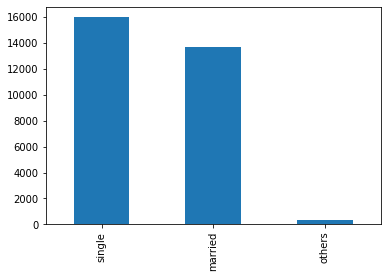

In [12]:
df['marriage'].map(marriage).value_counts().plot(kind='bar')

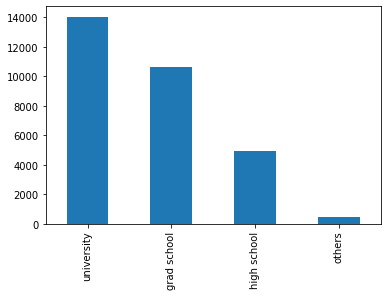

In [13]:
df['education'].map(education).value_counts().plot(kind='bar')

Checking distribution of categorical variables with regards to target variable

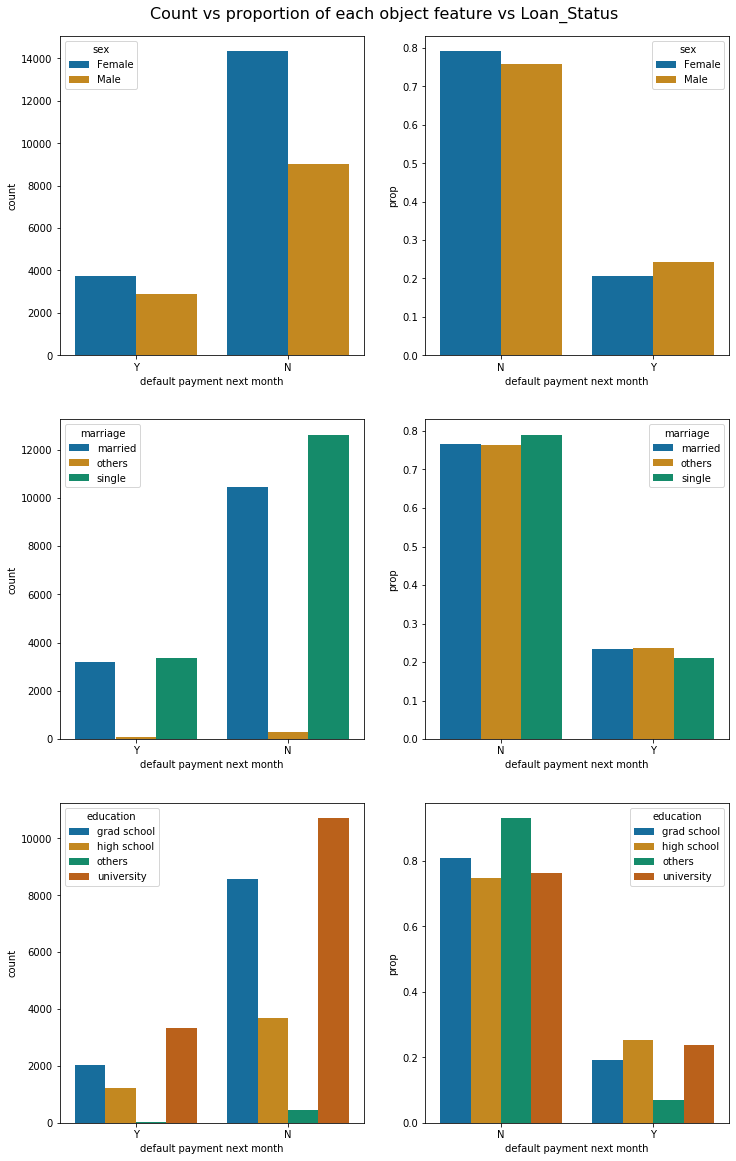

In [14]:
column_names = ['sex', 'marriage', 'education', 'default payment next month']
df1 = pd.DataFrame(columns = column_names)
df1['default payment next month'] = df['default payment next month'].map(default)
df1['sex'] = df['sex'].map(sex)
df1['marriage'] = df['marriage'].map(marriage)
df1['education'] = df['education'].map(education)

def prop_check(data):
    f, axes = plt.subplots(3,2,figsize= (12,20))
    plt.suptitle('Count vs proportion of each object feature vs Loan_Status', size =16, y = 0.9)
    col = ['sex', 'marriage', 'education']
    r = 0
    for i in col:
        if (data.dtypes == 'object')[i]:        
            data_prop = (data['default payment next month']
                          .groupby(data[i])
                          .value_counts(normalize = True)
                          .rename('prop')
                          .reset_index())
            sns.countplot(data = data, 
                          x ='default payment next month', 
                          hue = i, 
                          ax = axes[r,0], 
                          hue_order=data_prop[i].unique(), 
                          palette=current_palette)
            sns.barplot(data = data_prop, 
                        x = 'default payment next month', 
                        y = 'prop',
                        hue = i,
                        ax = axes[r,1],
                        palette=current_palette)
            r = r+1
prop_check(df1)

In [15]:
df['limit_bal'].value_counts().head(5)

50000     3365
20000     1976
30000     1610
80000     1567
200000    1528
Name: limit_bal, dtype: int64

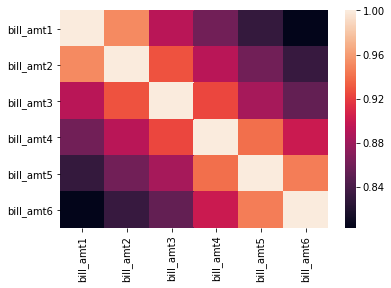

In [16]:
bill_amt_c = ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']
ax = sns.heatmap(df[bill_amt_c].corr())

Correlation is decreasing with increasing time passed between months i.e. lower correlation between bill_amt6 and bill_amt1

In [17]:
y = df['default payment next month']
X = df.drop(columns=['default payment next month'])

In [18]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

# Using cross validation and pipeline

Feature Engineering

In [19]:
#age bin
def age_bin(X):
    if X['age'] > 20 and X['age'] < 29:
        return 1
    elif X['age'] >= 29 and X['age'] < 46:
        return 2
    elif X['age'] >= 46 and X['age'] < 60:
        return 3
    else:
        return 4

age = FunctionTransformer(lambda x: x.apply(age_bin, axis=1).to_numpy().reshape(-1,1))   

#pro time delinquent
def prop_time_delinquent(X):
    I1 = 1 if X['pay_0'] > 0 else 0
    I2 = 1 if X['pay_2'] > 0 else 0
    I3 = 1 if X['pay_3'] > 0 else 0
    I4 = 1 if X['pay_4'] > 0 else 0
    I5 = 1 if X['pay_5'] > 0 else 0
    I6 = 1 if X['pay_6'] > 0 else 0

    return (I1+I2+I3+I4+I5+I6)/6

delinq = FunctionTransformer(lambda x: x.apply(prop_time_delinquent, axis=1).to_numpy().reshape(-1,1))

#delinquent_indicator
def del_indicator(X):
    if (X['pay_0'] > 0 or X['pay_2'] > 0 or X['pay_3'] > 0 or X['pay_4'] > 0 or X['pay_5'] > 0 or X['pay_6'] > 0):
        return 1
    else:
        return 0

del_ind = FunctionTransformer(lambda x: x.apply(del_indicator, axis=1).to_numpy().reshape(-1,1))

#ave_rel_outstanding
def ave_rel_outstanding(X):
    bill_amt = X.loc[: , 'bill_amt1':'bill_amt6']
    bill_amt.columns = ['1', '2', '3', '4', '5', '6']
    pay_amt = X.loc[: , 'pay_amt1':'pay_amt6']
    pay_amt.columns = ['1', '2', '3', '4', '5', '6']
    rel_outstanding = bill_amt.subtract(pay_amt).div(X['limit_bal'], axis=0)
    return rel_outstanding.mean(axis=1)

rel_out = FunctionTransformer(lambda x: ave_rel_outstanding(x).to_numpy().reshape(-1,1))

#avg_credit_utilization
def avg_credit_util(X):
    bill_amt_c = ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']
    feat = pd.DataFrame()
    for c in bill_amt_c:
        feat[c] = X[c]/X['limit_bal']
    return feat.mean(axis=1)

avg_util = FunctionTransformer(lambda x: x.apply(avg_credit_util, axis=1).to_numpy().reshape(-1,1))

In [20]:
to_scale = ['limit_bal', 'age', 'pay_amt1', 'pay_amt2',
       'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

to_pca = ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']


pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']


mapper = DataFrameMapper([
    ('sex', None),
    (pay_cols, OneHotEncoder(handle_unknown='ignore'), {'alias': 'pay'}),
    (['marriage'], OneHotEncoder(handle_unknown='ignore'), {'alias': 'marriage'}),
    (['education'], OneHotEncoder(handle_unknown='ignore'), {'alias': 'education'}),
    (to_scale, StandardScaler(), {'alias': 'scaled'}),
    (to_pca, make_pipeline(StandardScaler(), PCA(3)), {'alias': 'pca'})
])

In [21]:
all_features = FeatureUnion([('mapper', mapper), ('delinq', delinq), ('del_ind', del_ind), ('rel_out', rel_out), ('age', age)])

In [22]:
#Create DataFrame with all variables used in the classifiers below:

X_map = mapper.fit_transform(X)
cols = mapper.transformed_names_
cols.append('delinq')
cols.append('del_ind')
cols.append('rel_out')
cols.append('age')

Logistic Regression

In [25]:
pipe = Pipeline([
    ('featurize', all_features),
    ('feature_selection', SelectFromModel(LogisticRegression(C=1, penalty='l2'))),
    ('lm', LogisticRegression())])

param_grid = {
    'lm__C': np.logspace(-4, 4, 4),
}

#need to fit pipeline and print out support metrics in order to get selected features (only needed once)
pipe.fit(X,y)
support = pipe.named_steps['feature_selection'].get_support()

#calling pipeline with gridsearch
log_reg = GridSearchCV(pipe, param_grid, n_jobs=-1)
log_reg.fit(X, y)


print("CV scores for best parameters (CV score=%0.5f):" % log_reg.best_score_)
print('Best parameters: ', log_reg.best_params_)
print('Train Accuracy :', log_reg.best_estimator_.score(X,y))

predicted_lr = log_reg.best_estimator_.predict(X_test)
print('See below the classification report based on Test data')
print(classification_report(y_test, predicted_lr))

#computing default probabilities for risk management on train data
default_proba_lr = log_reg.best_estimator_.predict_proba(X)[:, 1]
default_proba_lr_test = log_reg.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y, default_proba_lr)
print('AUC score for Logistic Regression on train data is',round(auc(fpr, tpr),4))

fpr_test, tpr_test, thresholds = roc_curve(y_test, default_proba_lr_test)
print('AUC score for Logistic Regression on test data is',round(auc(fpr_test, tpr_test),4))

CV scores for best parameters (CV score=0.82021):
Best parameters:  {'lm__C': 0.046415888336127774}
Train Accuracy : 0.820375
See below the classification report based on Test data
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      4635
           1       0.74      0.32      0.45      1365

    accuracy                           0.82      6000
   macro avg       0.78      0.64      0.67      6000
weighted avg       0.81      0.82      0.79      6000

AUC score for Logistic Regression on train data is 0.7583
AUC score for Logistic Regression on test data is 0.7738


LightGBM

In [54]:
pipe = Pipeline([
    ('featurize', all_features),
    ('feature_selection', SelectFromModel(LogisticRegression(C=1, penalty='l2'))),
    ('lgb', LGBMClassifier())])

param_grid ={  
             'lgb__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'lgb__max_depth': [5, 10, 15],
             'lgb__learning_rate': [0.1, 0.05]}

#calling pipeline with gridsearch
lgb = GridSearchCV(pipe, param_grid, n_jobs=-1)
lgb.fit(X, y)


print("CV scores for best parameters (CV score=%0.5f):" % lgb.best_score_)
print('Best parameters: ', lgb.best_params_)
print('Train Accuracy :', lgb.best_estimator_.score(X,y))

predicted_lgb = lgb.best_estimator_.predict(X_test)
print('See below the classification report based on Test data')
print(classification_report(y_test, predicted_lgb))

#computing default probabilities for risk management on train data
default_proba_lgb = lgb.best_estimator_.predict_proba(X)[:, 1]
default_proba_lgb_test = lgb.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y, default_proba_lgb)
print('AUC score for LightGBM on train data is',round(auc(fpr, tpr),4))

fpr_test, tpr_test, thresholds = roc_curve(y_test, default_proba_lgb_test)
print('AUC score for LightGBM on test data is',round(auc(fpr_test, tpr_test),4))

CV scores for best parameters (CV score=0.82075):
Best parameters:  {'lgb__learning_rate': 0.05, 'lgb__max_depth': 15, 'lgb__min_child_weight': 1}
Train Accuracy : 0.824625
See below the classification report based on Test data
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4635
           1       0.71      0.35      0.47      1365

    accuracy                           0.82      6000
   macro avg       0.77      0.65      0.68      6000
weighted avg       0.81      0.82      0.80      6000

AUC score for LightGBM on train data is 0.7771
AUC score for LightGBM on test data is 0.7738


MLP Classifier

In [55]:
pipe = Pipeline([
    ('featurize', all_features),
    ('feature_selection', SelectFromModel(LogisticRegression(C=1, penalty='l2'))),
    ('MLPClassifier', MLPClassifier(random_state = 42))])

param_grid = [{
    'MLPClassifier__solver': ['lbfgs', 'sgd', 'adam'],
    'MLPClassifier__max_iter': [100,200,300,500],
    'MLPClassifier__activation' : ['relu','logistic','tanh'],
    'MLPClassifier__hidden_layer_sizes':[(2,), (4,),(2,2),(4,4),(4,2),(10,10),(2,2,2)],}]

#calling pipeline with gridsearch
mlp = GridSearchCV(pipe, param_grid, n_jobs=-1)
mlp.fit(X, y)


print("CV scores for best parameters (CV score=%0.5f):" % mlp.best_score_)
print('Best parameters: ',mlp.best_params_)
print('Train Accuracy :', mlp.best_estimator_.score(X,y))

predicted_mlp = mlp.best_estimator_.predict(X_test)
print('See below the classification report based on Test data')
print(classification_report(y_test, predicted_mlp))

#computing default probabilities for risk management on train data
default_proba_mlp = mlp.best_estimator_.predict_proba(X)[:, 1]
default_proba_mlp_test = mlp.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y, default_proba_mlp)
print('AUC score for MLP on train data is',round(auc(fpr, tpr),4))

fpr_test, tpr_test, thresholds = roc_curve(y_test, default_proba_mlp_test)
print('AUC score for MLP on test data is',round(auc(fpr_test, tpr_test),4))

CV scores for best parameters (CV score=0.82183):
Best parameters:  {'MLPClassifier__activation': 'tanh', 'MLPClassifier__hidden_layer_sizes': (4, 4), 'MLPClassifier__max_iter': 100, 'MLPClassifier__solver': 'lbfgs'}
Train Accuracy : 0.822875
See below the classification report based on Test data
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      4635
           1       0.71      0.36      0.48      1365

    accuracy                           0.82      6000
   macro avg       0.77      0.66      0.69      6000
weighted avg       0.81      0.82      0.80      6000

AUC score for MLP on train data is 0.7605
AUC score for MLP on test data is 0.7738


Checking significant features fed into above models based on Ridge Regression

In [59]:
#Filter all columns passed to the pipeline by just the one classified as significant:
df = pd.DataFrame(data=support, columns=['significant'],index=cols)
sign = df[(df['significant']== True)]

In [60]:
sign

,significant
pay_x0_-1,True
pay_x0_1,True
pay_x0_2,True
pay_x0_3,True
pay_x0_4,True
pay_x0_6,True
pay_x0_7,True
pay_x1_4,True
pay_x1_6,True
pay_x1_7,True


# Portfolio Metrics using Model Output

In [26]:
# Calculate the outstanding balance as total bill amount- total pay amount
X1=X.reset_index()
bill_amt = X1.loc[: , 'bill_amt1':'bill_amt6']
bill_amt.columns = ['1', '2', '3', '4', '5', '6']
pay_amt = X1.loc[: , 'pay_amt1':'pay_amt6']
pay_amt.columns = ['1', '2', '3', '4', '5', '6']
rel_outstanding = bill_amt.subtract(pay_amt)
X1["EAD"] = rel_outstanding.apply(lambda row: row['1' : '6'].sum(),axis=1)


In [27]:
# PD -- probability default figures derived from logistic regression
# EAD -- Relative outstanding balance derived earlier * limit balance
# ECL -- PD*EAD
ecl = pd.DataFrame(columns=['PD','EAD','ECL'])

for i in range(len(default_proba_lr)):
    ecl.loc[i,'PD']=default_proba_lr[i]
    if X1.loc[i,'EAD'] <0:
        ecl.loc[i,'EAD']=0
    else:
        ecl.loc[i,'EAD']=X1.loc[i,'EAD']
    ecl.loc[i,'ECL']=ecl.loc[i,'PD']*ecl.loc[i,'EAD']

In [28]:
# Do a Monte Carlo Simulation for 100000 runs In each run, randomly select samples of 2000 accounts.
# To account for high absolute ECL figures, divide it by total EAD for the sample 
loss_portfolio=[]
for i in range(100000):
    random_data = ecl.sample(2000)
    loss_perc = sum(random_data['ECL'])/sum(random_data['EAD'])
    loss_portfolio.append(loss_perc)

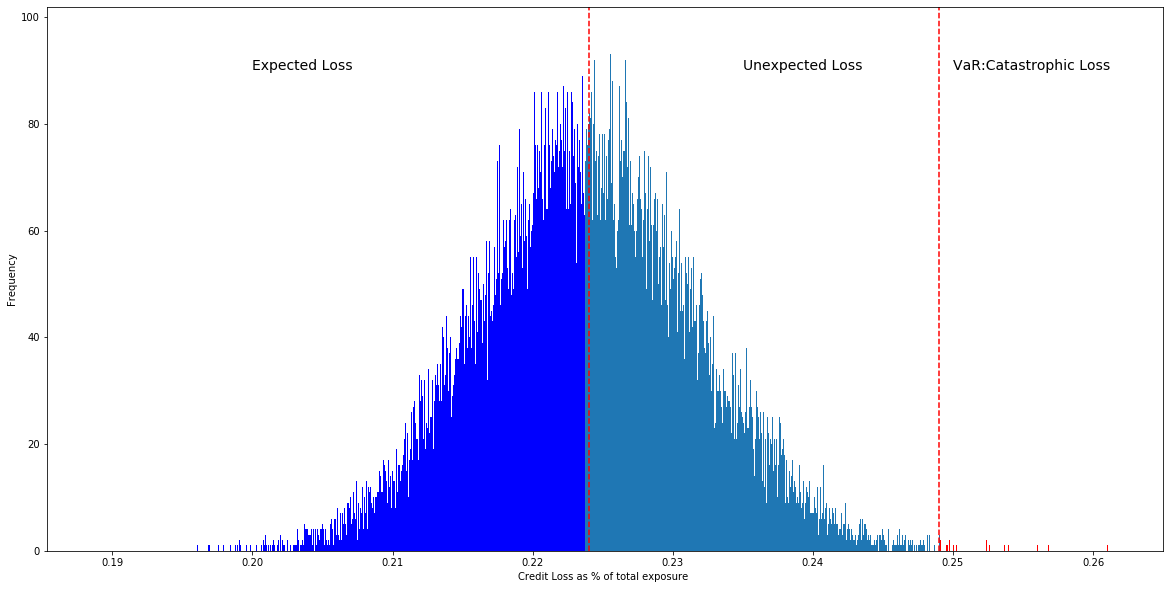

In [49]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.xlabel('Credit Loss as % of total exposure ')
plt.ylabel('Frequency')

N, bins, patches = plt.hist(loss_portfolio,bins=5000, linewidth=1)

for i in range(0,2400):
    patches[i].set_facecolor('blue')
for i in range(4150, len(patches)):
    patches[i].set_facecolor('red')

plt.axvline(x=0.224, color='red', linestyle='--')
plt.axvline(x=0.249, color='red', linestyle='--')
plt.text(0.20,90,'Expected Loss',fontsize=14)
plt.text(0.235,90,'Unexpected Loss',fontsize=14)
plt.text(0.25,90,'VaR:Catastrophic Loss',fontsize=14)
plt.show()

Calculating VaR at 99.9% confidence interval

In [38]:
WCL = np.quantile(loss_portfolio,0.999)
EL = np.mean(loss_portfolio)
print('Expected Loss={}, Value at Risk={}'.format(round(EL,3),round(WCL,3)))

Expected Loss=0.224, Value at Risk=0.249
